# V Flat

0 g: V0 = 1.47080 V ± 0.00003 V
+1 g: V+g = 1.77318 V ± 0.00001 V
-1 g: V-g = 1.18790 V ± 0.00001 V

Systematic Calibration Errors:
  0 g: Expected V0 = 1.50000 V, Measured = 1.47080 V, Error = 0.02920 V
  +1 g: Expected V+g = 1.80000 V, Measured = 1.77318 V, Error = 0.02682 V
  -1 g: Expected V-g = 1.20000 V, Measured = 1.18790 V, Error = 0.01210 V

Weighted Linear Fit Results:
  Sensitivity (m): 0.29256 V/g ± 0.00210 V/g
  Zero-g voltage (b): 1.48009 V ± 0.00205 V

Calibration Conversion Formula:
  a(V) = 9.81 * (V - 1.48009) / 0.29256


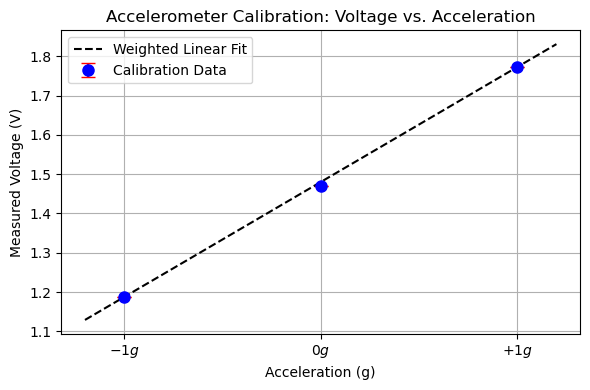

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt

# ================== SETUP DIRECTORIES ==================
data_dir_base = "/home/jupyter/phys234/Lab5"  # Base directory for your data files
save_dir = "./ProcessedData/"
os.makedirs(save_dir, exist_ok=True)

# Define file names for each calibration point
file_0g    = "0g.lvm"         # file for 0 g measurements
file_pos   = "positiveg.lvm"  # file for +1 g measurements
file_neg   = "negativeg.lvm"  # file for -1 g measurements

def process_voltage_file(filepath, skip_header=1):
    """
    Reads the file (assumes tab-delimited with a header),
    extracts the accelerometer voltage (assumed to be the 2nd column),
    and computes the mean and standard error (uncertainty) of the voltage.
    """
    data = np.genfromtxt(filepath, delimiter="\t", skip_header=skip_header)
    # Assuming columns: time, V_acc, V_in
    V_acc = data[:, 1]
    avg = np.mean(V_acc)
    std = np.std(V_acc, ddof=1)  # sample standard deviation
    N = len(V_acc)
    uncertainty = std / np.sqrt(N)  # standard error of the mean
    return avg, uncertainty

# Process 0 g data
filepath_0g = os.path.join(data_dir_base, file_0g)
avg_V0, unc_V0 = process_voltage_file(filepath_0g, skip_header=0)
print(f"0 g: V0 = {avg_V0:.5f} V ± {unc_V0:.5f} V")

# Process +1 g data
filepath_pos = os.path.join(data_dir_base, file_pos)
avg_pos, unc_pos = process_voltage_file(filepath_pos, skip_header=0)
print(f"+1 g: V+g = {avg_pos:.5f} V ± {unc_pos:.5f} V")

# Process -1 g data
filepath_neg = os.path.join(data_dir_base, file_neg)
avg_neg, unc_neg = process_voltage_file(filepath_neg, skip_header=0)
print(f"-1 g: V-g = {avg_neg:.5f} V ± {unc_neg:.5f} V")

# ------------------- Calculate Systematic (Calibration) Errors ------------------- 
# Nominal expected values (for a 3 V supply and nominal 0.30 V/g sensitivity):
expected_V0   = 1.50000   # expected zero-g voltage
expected_pos  = 1.50000 + 0.30  # expected +1 g voltage = 1.80000 V
expected_neg  = 1.50000 - 0.30  # expected -1 g voltage = 1.20000 V

error_V0  = expected_V0  - avg_V0
error_pos = expected_pos - avg_pos
error_neg = expected_neg - avg_neg

print("\nSystematic Calibration Errors:")
print(f"  0 g: Expected V0 = {expected_V0:.5f} V, Measured = {avg_V0:.5f} V, Error = {error_V0:.5f} V")
print(f"  +1 g: Expected V+g = {expected_pos:.5f} V, Measured = {avg_pos:.5f} V, Error = {error_pos:.5f} V")
print(f"  -1 g: Expected V-g = {expected_neg:.5f} V, Measured = {avg_neg:.5f} V, Error = {error_neg:.5f} V")

# ------------------- Weighted Linear Fit (to determine sensitivity and V0) -------------------
# Define acceleration values in g for the three calibration points.
accel_values = np.array([-1, 0, 1])  # corresponding to -1 g, 0 g, +1 g
voltages = np.array([avg_neg, avg_V0, avg_pos])
voltage_uncertainties = np.array([unc_neg, unc_V0, unc_pos])

# Perform weighted linear fit: V = m*a + b, where m is the sensitivity (V/g) and b is V0.
# Weights are given by 1/(uncertainty)
p, cov = np.polyfit(accel_values, voltages, 1, w=1/voltage_uncertainties, cov=True)
m_fit = p[0]     # fitted sensitivity in V/g
b_fit = p[1]     # fitted zero-g voltage
m_fit_err = np.sqrt(cov[0, 0])
b_fit_err = np.sqrt(cov[1, 1])

print("\nWeighted Linear Fit Results:")
print(f"  Sensitivity (m): {m_fit:.5f} V/g ± {m_fit_err:.5f} V/g")
print(f"  Zero-g voltage (b): {b_fit:.5f} V ± {b_fit_err:.5f} V")

# Define the calibration conversion function using the weighted fit:
# a(V) = g * (V - b) / m, with g = 9.81 m/s².
g_val = 9.81
def calibration_acceleration(V):
    return g_val * (V - b_fit) / m_fit

print("\nCalibration Conversion Formula:")
print(f"  a(V) = {g_val:.2f} * (V - {b_fit:.5f}) / {m_fit:.5f}")

# ------------------- Plotting Calibration Data and Fit -------------------
plt.figure(figsize=(6,4))
plt.errorbar(accel_values, voltages, yerr=voltage_uncertainties, fmt='o', capsize=5, markersize=8,
             color='b', ecolor='r', label="Calibration Data")

# Generate a smooth fit line for plotting.
a_fit = np.linspace(-1.2, 1.2, 100)
V_fit = m_fit * a_fit + b_fit
plt.plot(a_fit, V_fit, 'k--', label="Weighted Linear Fit")

plt.xlabel("Acceleration (g)")
plt.ylabel("Measured Voltage (V)")
plt.title("Accelerometer Calibration: Voltage vs. Acceleration")
plt.xticks(accel_values, [r"$-1g$", r"$0g$", r"$+1g$"])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
